# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

<img src='../figures/RegressaoSoftmax_CrossEntropy_Otimizacao.png',width=700></img>

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

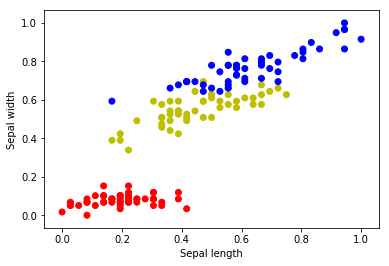

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

<img src='../figures/RegressaoLogisticaRede_2_3.png',width=400></a>

In [4]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

### Fazendo um predict

In [5]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

Variable containing:
-0.4342 -0.5073  0.1803
-0.4480 -0.5401  0.2113
-0.4549 -0.5732  0.2357
-0.4757 -0.5892  0.2647
[torch.FloatTensor of size 4x3]

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

<img src='../figures/softmax.png', width=600>

In [6]:
F.softmax(out)*100

Variable containing:
 26.4681  24.6026  48.9292
 26.0038  23.7159  50.2803
 25.7503  22.8790  51.3706
 25.0652  22.3758  52.5589
[torch.FloatTensor of size 4x3]

### Predição da classe

In [7]:
_,y_pred = torch.max(out,1)
y_pred

Variable containing:
 2
 2
 2
 2
[torch.LongTensor of size 4]

## Treinamento

### Classe para visualização dinâmica

In [8]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = nn.functional.softmax(outputs)
    predicts, _ = torch.max(outputs, 1)
    
    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            
            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)
                
                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)
                
                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                    
                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [9]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.3188087046146393


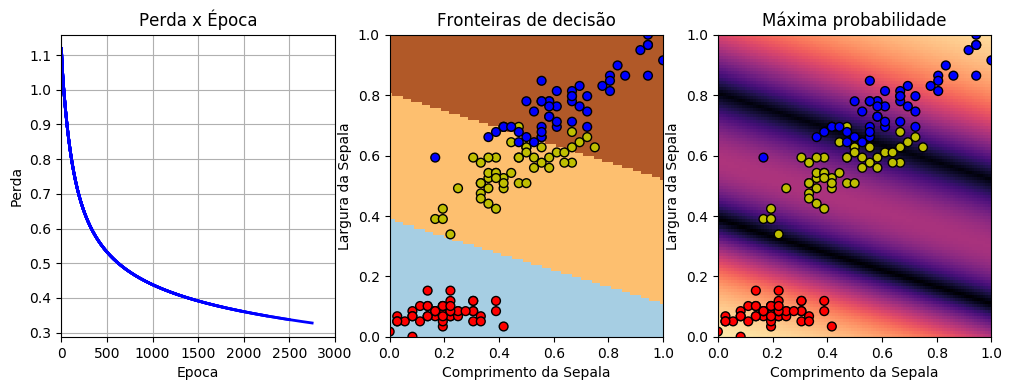

In [10]:
nb_epoch = 3000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data[0])
    
    my_plot.on_epoch_end(i, {'loss': loss.data[0]});
    
print('Final loss:', loss.data[0])

## Avaliação

### Parâmetros após treinamento

In [11]:
model.state_dict()

OrderedDict([('weight', 
              -2.4129 -9.1045
               0.3958  0.9481
               2.2984  8.1548
              [torch.FloatTensor of size 3x2]), ('bias', 
               4.1932
               0.3453
              -5.3621
              [torch.FloatTensor of size 3])])

### Salvando os parâmetros treinados

In [12]:
os.makedirs('../../models',exist_ok=True)
torch.save(model.state_dict(),'../../models/RegrLog_Iris.pt')

In [13]:
nn.init.constant(model.weight,0)

Parameter containing:
 0  0
 0  0
 0  0
[torch.FloatTensor of size 3x2]

### Recuperando os pesos salvos

In [14]:
param_saved = torch.load('../../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [15]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.92


### Matriz de confusão

In [16]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,43,5
2,0,7,45


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
3. Quantas entradas e quantas saídas esta rede possui?
4. Como se pode calcular a acurácia a partir da matriz de confusão?
5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

### Exercícios:

1. Experimente refazer o treinamento com diferentes valores de learning rate
2. Na opção de mostrar o valor das probabilidades no gráfico do espaço de atributos,
troque a tabela de cores **magma** utilizada no `pcolormesh` que está com o parâmetro `cmap=plt.cm.magma`. Escolha a tabela de cores consultando o manual do matplotlib:
    - https://matplotlib.org/users/colormaps.html
3. Qual é a amostra classificada corretamente, com maior probabilidade?
4. Qual é a amostra classificada erradamente, com maior probabilidade?
5. Qual é a amostra classificada corretamente, com menor probabilidade?
6. Qual é a amostra classificada erradamente, com menor probabilidade?

## Principais aprendizados